# TCI simulation

This notebook is a simulation of the TCI (Target-Controlled Infusion) system. The TCI system is a system that controls the infusion of a drug into a patient's body to maintain a desired concentration of the drug in the blood. It is an open-loop controller that uses a pharmacokinetic model to predict the drug concentration in the blood based on the infusion rate. The system is used in anesthesia to maintain a desired level of anesthesia in the patient.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from python_anesthesia_simulator import Patient, TCIController
import vitaldb as vdb
pd.options.mode.chained_assignment = None 

## Definition of the patient model and the TCI system

In this cell, we create an instance of the `Patient` class, which represents the patient model and two instances of the `TCI` class, one for propofol, the other for remifentanil.

In [2]:
age = 50
height = 170
weight = 70
gender = 0

patient_info = [age, height, weight, gender]

#init the patient simulation
patient = Patient(patient_info, model_propo='Schnider', model_remi='Minto')

# initialize TCI
concentration = 10 #mg/ml for Propofol and µg/ml for remifentanil
tci_propo = TCIController(patient_info, drug_name='Propofol', model_used="Schnider", drug_concentration=concentration)
tci_remi = TCIController(patient_info, drug_name='Remifentanil', model_used="Minto", drug_concentration=concentration)

/home/aubouinb/Nextcloud2/Code/hypotension_pred/.venv/lib/python3.12/site-packages/python_anesthesia_simulator/simulator.py:584: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.dataframe = pd.concat((self.dataframe, pd.DataFrame(new_line, index=[1])), ignore_index=True)


## Simulation

In [3]:
sampling_time = 1 # seconds
N_simu = 5*60 // sampling_time # 10 minutes

propo_target = 4 # ug/ml
remi_target = 3 # ng/ml

for time_step in range(N_simu):
    u_propo = tci_propo.one_step(propo_target) # in ml/h
    u_remi = tci_remi.one_step(remi_target) # in ml/h

    patient.one_step(u_propo/3600 * concentration, u_remi/3600 * concentration)



## Results

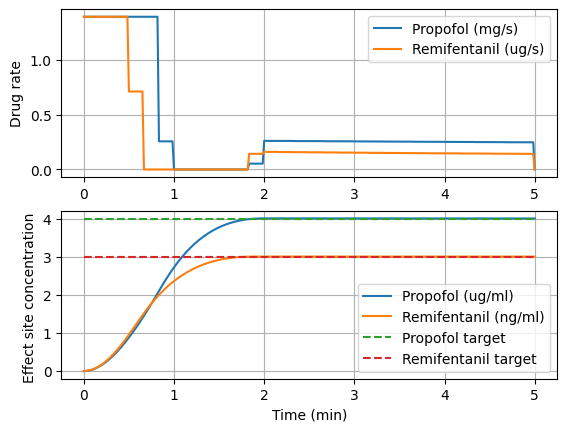

In [4]:
# plot effect site concentration and control input

plt.subplot(2, 1, 1)
plt.plot(patient.dataframe['Time']/60, patient.dataframe['u_propo'], label='Propofol (mg/s)')
plt.plot(patient.dataframe['Time']/60, patient.dataframe['u_remi'], label='Remifentanil (ug/s)')
plt.ylabel('Drug rate')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(patient.dataframe['Time']/60, patient.dataframe['x_propo_4'], label='Propofol (ug/ml)')
plt.plot(patient.dataframe['Time']/60, patient.dataframe['x_remi_4'], label='Remifentanil (ng/ml)')
#plot target
plt.plot(patient.dataframe['Time']/60, [propo_target]*len(patient.dataframe['Time']), '--', label='Propofol target')
plt.plot(patient.dataframe['Time']/60, [remi_target]*len(patient.dataframe['Time']), '--', label='Remifentanil target')
plt.ylabel('Effect site concentration ')
plt.xlabel('Time (min)')
plt.legend()
plt.grid()

plt.show()


## Test on clinical data

In this section we compare the output of the TCI algorithm with the clinical data comming from the open source vitalDB database (https://vitaldb.net)

In [5]:
#load vital DB data
main_signals = ['BIS/BIS',
                'Orchestra/PPF20_RATE', # Propofole rate in ml/h
                'Orchestra/PPF20_CT', # Propofol target concentration in ug/ml
                'Orchestra/PPF20_CE', # Propofol effect site concentration in ug/ml
                'Orchestra/RFTN20_RATE', # Remifentanil rate in ml/h
                'Orchestra/RFTN20_CT', # Remifentanil target concentration in ng/ml
                'Orchestra/RFTN20_CE', # Remifentanil effect site concentration in ng/ml
                 ]

#all the drugs measurement are from the TCI device

sampling_time = 1 # seconds
case_id = 46
# get the data from the vitaldb
data_vitalDB = vdb.VitalFile(int(case_id), track_names=main_signals).to_pandas(
        track_names=main_signals, interval=sampling_time)
start = data_vitalDB[(data_vitalDB['Orchestra/PPF20_RATE'] > 0) | (data_vitalDB['Orchestra/RFTN20_RATE'] > 0)].index[0]
data_vitalDB = data_vitalDB.loc[start:]
data_vitalDB.ffill(inplace=True)
data_vitalDB.fillna(0, inplace=True)
# get patient personnal information
patient_info = pd.read_csv("https://api.vitaldb.net/cases")
patient_info = patient_info[patient_info['caseid'] == case_id]
age = patient_info['age'].values[0]
height = patient_info['height'].values[0]
weight = patient_info['weight'].values[0]
gender = int(patient_info['sex'].values[0] == 'M')
concentration_vdb = 20

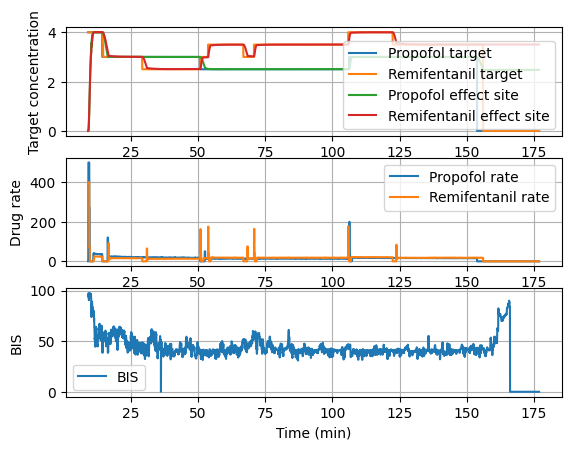

In [6]:
#plot clinical data
plt.subplot(3, 1, 1)
plt.plot(data_vitalDB.index/60, data_vitalDB['Orchestra/PPF20_CT'], label='Propofol target')
plt.plot(data_vitalDB.index/60, data_vitalDB['Orchestra/RFTN20_CT'], label='Remifentanil target')
plt.plot(data_vitalDB.index/60, data_vitalDB['Orchestra/PPF20_CE'], label='Propofol effect site')
plt.plot(data_vitalDB.index/60, data_vitalDB['Orchestra/RFTN20_CE'], label='Remifentanil effect site')
plt.ylabel('Target concentration')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data_vitalDB.index/60, data_vitalDB['Orchestra/PPF20_RATE'], label='Propofol rate')
plt.plot(data_vitalDB.index/60, data_vitalDB['Orchestra/RFTN20_RATE'], label='Remifentanil rate')
plt.ylabel('Drug rate')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(data_vitalDB.index/60, data_vitalDB['BIS/BIS'], label='BIS')
plt.ylabel('BIS')
plt.xlabel('Time (min)')
plt.legend()
plt.grid()

plt.show()

In [7]:
# simulate with the clinical data as input
TCI_propo = TCIController([age, height, weight, gender], drug_name='Propofol', model_used="Marsh_modified", drug_concentration=concentration_vdb)
TCI_remi = TCIController([age, height, weight, gender], drug_name='Remifentanil', model_used="Minto", drug_concentration=concentration_vdb)
Patient_simu_TCI = Patient([age, height, weight, gender], model_propo='Marsh_modified', model_remi='Minto')
Patient_simu_VitaldDB = Patient([age, height, weight, gender], model_propo='Marsh_modified', model_remi='Minto')
data_vitalDB['simulated_propo_rate'] = 0
data_vitalDB['simulated_remi_rate'] = 0
for i in range(len(data_vitalDB)):
    propo_target = data_vitalDB['Orchestra/PPF20_CT'].iloc[i] # in ug/ml
    remi_target = data_vitalDB['Orchestra/RFTN20_CT'].iloc[i] # in ng/ml
    data_vitalDB['simulated_propo_rate'].iloc[i] = TCI_propo.one_step(propo_target) # in ml/h
    data_vitalDB['simulated_remi_rate'].iloc[i] = TCI_remi.one_step(remi_target) # in ml/h
    Patient_simu_TCI.one_step(u_propo=data_vitalDB['simulated_propo_rate'].iloc[i]/3600 * concentration_vdb,
                              u_remi=data_vitalDB['simulated_remi_rate'].iloc[i]/3600 * concentration_vdb)
    Patient_simu_VitaldDB.one_step(u_propo=data_vitalDB['Orchestra/PPF20_RATE'].iloc[i]/3600* concentration_vdb,
                                   u_remi=data_vitalDB['Orchestra/RFTN20_RATE'].iloc[i]/3600 * concentration_vdb)



/home/aubouinb/Nextcloud2/Code/hypotension_pred/.venv/lib/python3.12/site-packages/python_anesthesia_simulator/simulator.py:584: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.dataframe = pd.concat((self.dataframe, pd.DataFrame(new_line, index=[1])), ignore_index=True)
/home/aubouinb/Nextcloud2/Code/hypotension_pred/.venv/lib/python3.12/site-packages/python_anesthesia_simulator/simulator.py:584: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.dataframe = pd.concat((self.dataframe, pd.Data

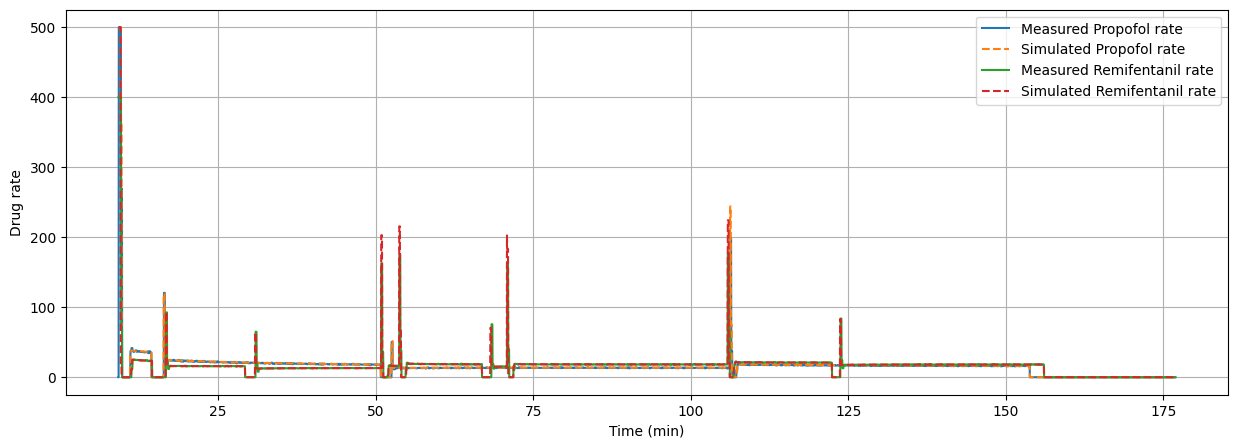

In [8]:

# plot the data
plt.figure(figsize=(15, 5))
plt.plot(data_vitalDB.index/60, data_vitalDB['Orchestra/PPF20_RATE'], label='Measured Propofol rate')
plt.plot(data_vitalDB.index/60, data_vitalDB['simulated_propo_rate'], '--', label='Simulated Propofol rate')
plt.plot(data_vitalDB.index/60, data_vitalDB['Orchestra/RFTN20_RATE'], label='Measured Remifentanil rate')
plt.plot(data_vitalDB.index/60, data_vitalDB['simulated_remi_rate'], '--', label='Simulated Remifentanil rate')
plt.xlabel('Time (min)')
plt.ylabel('Drug rate')
plt.legend()
plt.grid()
plt.show()

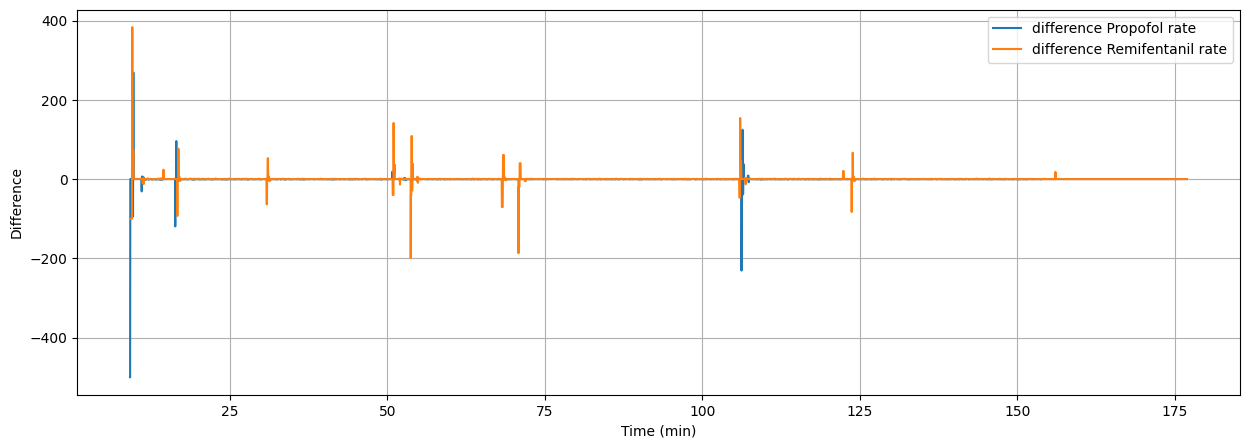

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(data_vitalDB.index/60, data_vitalDB['Orchestra/PPF20_RATE']-data_vitalDB['simulated_propo_rate'], label='difference Propofol rate')
plt.plot(data_vitalDB.index/60, data_vitalDB['Orchestra/RFTN20_RATE']-data_vitalDB['simulated_remi_rate'], label='difference Remifentanil rate')
plt.xlabel('Time (min)')
plt.ylabel('Difference')
plt.legend()
plt.grid()
plt.show()

Here we can observe some difference between the clinical data and the TCI algorithm implemented in PAS. While those differences are significant when looking at the drug rate, the drug concentrations are quite similar.

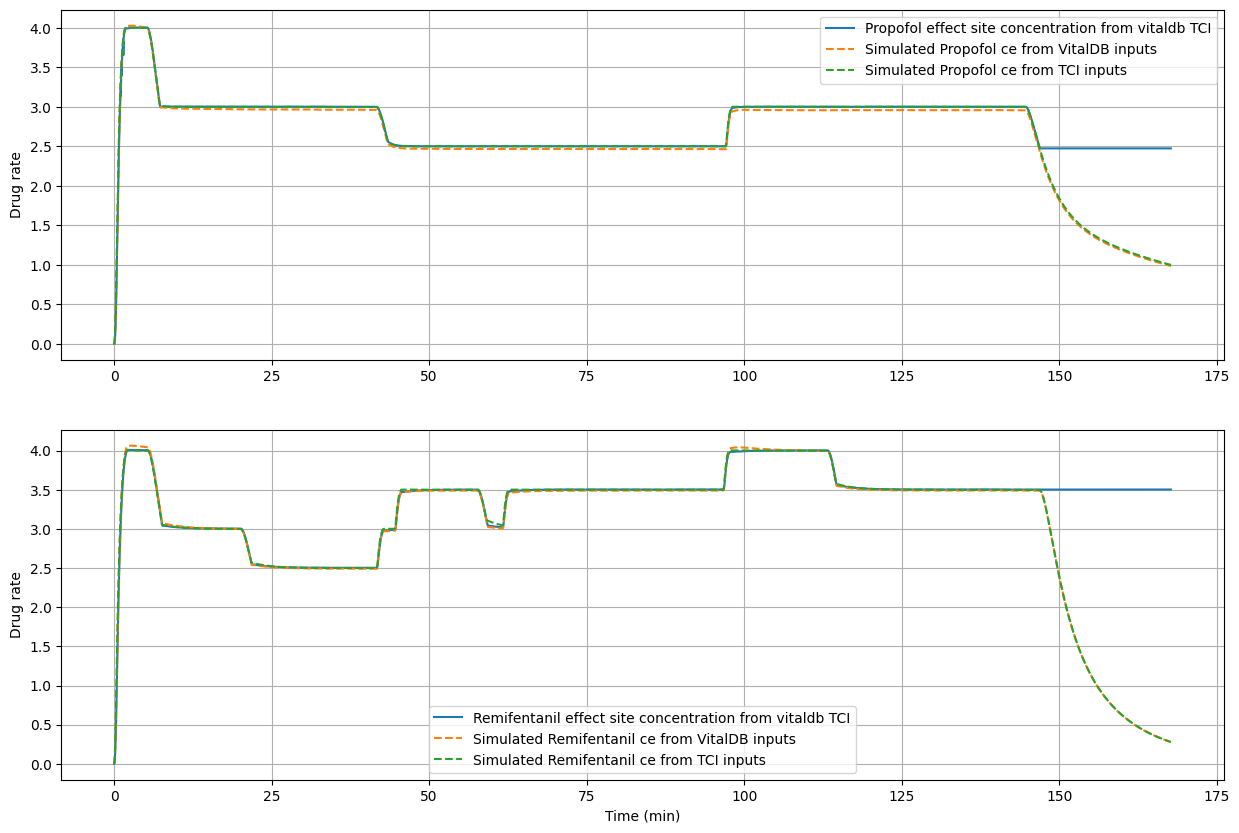

In [10]:
# plot the data
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot((data_vitalDB.index - data_vitalDB.index[0])/60, data_vitalDB['Orchestra/PPF20_CE'], label='Propofol effect site concentration from vitaldb TCI')
plt.plot(Patient_simu_VitaldDB.dataframe['Time']/60, Patient_simu_VitaldDB.dataframe['x_propo_4'],'--', label='Simulated Propofol ce from VitalDB inputs')
plt.plot(Patient_simu_TCI.dataframe['Time']/60, Patient_simu_TCI.dataframe['x_propo_4'],'--', label='Simulated Propofol ce from TCI inputs')
plt.ylabel('Drug rate')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot((data_vitalDB.index - data_vitalDB.index[0])/60, data_vitalDB['Orchestra/RFTN20_CE'], label='Remifentanil effect site concentration from vitaldb TCI')
plt.plot(Patient_simu_VitaldDB.dataframe['Time']/60, Patient_simu_VitaldDB.dataframe['x_remi_4'],'--', label='Simulated Remifentanil ce from VitalDB inputs')
plt.plot(Patient_simu_TCI.dataframe['Time']/60, Patient_simu_TCI.dataframe['x_remi_4'],'--', label='Simulated Remifentanil ce from TCI inputs')
plt.ylabel('Drug rate')
plt.xlabel('Time (min)')
plt.legend()
plt.grid()


plt.show()

The difference at the end might come from the ffill method used to fill the missing values in the clinical data.